In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
dt = 0.004
num_steps = 501
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([501, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

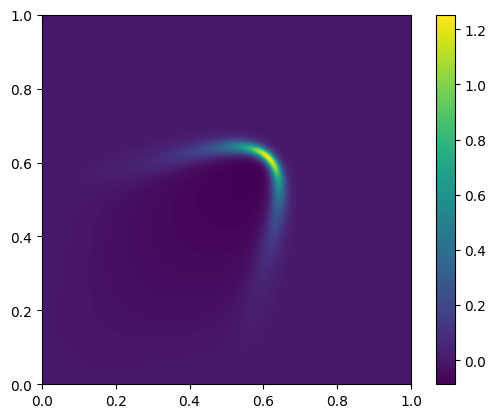

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = u_dot

In [8]:
N = datas.shape[1]
n = 20
mu = int(np.ceil(N/20))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [9]:
batch_size = 20
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [10]:
ed = lib.nrbs.EncoderDecoder(N=N, n=n, mu=mu, neighbours=neighbours, device=device)

In [11]:
encoded = ed.nrbs.encode(datas[:15].to(device))

In [12]:
ed.train(train_data_loader=train_data, epochs=1000)

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Itr 0, loss = 40445.10180041559


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 1, loss = 25677.577463164176


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 2, loss = 21703.158615171313


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 3, loss = 19794.871492171067


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 4, loss = 18552.096193207522


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 5, loss = 17528.256226290458


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 6, loss = 16607.53180964716


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 7, loss = 15431.152048662883


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 8, loss = 14440.324115780562


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 9, loss = 13608.260714320566


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 10, loss = 13086.04407991685


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 11, loss = 12776.401127854519


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 12, loss = 12412.423094625461


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 13, loss = 12345.41639516669


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 14, loss = 12235.66819582593


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 15, loss = 11899.409437576473


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 16, loss = 12247.536224884125


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 17, loss = 11812.659875739026


100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


Itr 18, loss = 11523.742916515595


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 19, loss = 11424.72281123454


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 20, loss = 11291.66140087045


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 21, loss = 11162.243787191832


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 22, loss = 11078.028532407987


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 23, loss = 10936.445917215939


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 24, loss = 11013.978511314564


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 25, loss = 10942.276781760238


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 26, loss = 10717.516211630287


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 27, loss = 10696.828862971253


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 28, loss = 10662.597895855975


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 29, loss = 10729.337742452377


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 30, loss = 10765.060176236651


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 31, loss = 10659.011325297339


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 32, loss = 10490.489978024358


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 33, loss = 10322.174237079238


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 34, loss = 10156.593912265058


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 35, loss = 10065.187836907175


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 36, loss = 10049.184779097552


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 37, loss = 10014.586284685152


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 38, loss = 9963.70596611837


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 39, loss = 10441.70996070219


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 40, loss = 11688.655340795354


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 41, loss = 12549.043908612926


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 42, loss = 10658.055068809654


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 43, loss = 9978.417862346338


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 44, loss = 9863.309335868362


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 45, loss = 9812.5664074354


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 46, loss = 9791.58980521651


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 47, loss = 9579.310768764963


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 48, loss = 9615.757981253912


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 49, loss = 9550.761206191324


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 50, loss = 9336.206176661362


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 51, loss = 9223.98465198201


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 52, loss = 9171.414333125436


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 53, loss = 9110.695470930783


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 54, loss = 9092.275055263199


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 55, loss = 9103.387735623592


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 56, loss = 9111.154110763782


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 57, loss = 9020.487104713859


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 58, loss = 9005.389800207606


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 59, loss = 9058.134166844111


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 60, loss = 9692.962199774602


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 61, loss = 11802.80529644119


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 62, loss = 10210.066248734123


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 63, loss = 9302.243660073213


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 64, loss = 8994.40842392552


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 65, loss = 9058.289815390775


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 66, loss = 9011.812882325685


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 67, loss = 8868.015736145751


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 68, loss = 8831.435789571691


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 69, loss = 8838.850449206693


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 70, loss = 8792.820850063501


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 71, loss = 8842.897653116428


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 72, loss = 8773.340400660638


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 73, loss = 8891.289140844961


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 74, loss = 9737.147854756959


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 75, loss = 9508.238908306621


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 76, loss = 9518.082038769253


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 77, loss = 9304.438844628163


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 78, loss = 9073.330735154206


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 79, loss = 9008.984237657776


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 80, loss = 9229.915738218413


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 81, loss = 9116.651191997125


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 82, loss = 9038.966342537053


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 83, loss = 9071.238557405723


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 84, loss = 9231.61742460005


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 85, loss = 9102.894630030469


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 86, loss = 8839.390707138666


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 87, loss = 8776.897673071242


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 88, loss = 8994.769718191448


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 89, loss = 8701.341475289273


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 90, loss = 8548.20425545517


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 91, loss = 8488.872517547414


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 92, loss = 8401.94643998808


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 93, loss = 8405.97140433267


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 94, loss = 8368.027890292642


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 95, loss = 8344.61213628517


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 96, loss = 8404.19883419224


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 97, loss = 8574.146016949897


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 98, loss = 8803.708980975855


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 99, loss = 9133.62164309908


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 100, loss = 9004.57397786985


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 101, loss = 8760.59438287264


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 102, loss = 8590.455471274598


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 103, loss = 8793.402636663834


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 104, loss = 9070.884270386867


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 105, loss = 8892.361183892546


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 106, loss = 9508.344493987119


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 107, loss = 10768.081938488458


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 108, loss = 10473.152497138386


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 109, loss = 9563.107997060888


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 110, loss = 9308.625202263524


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 111, loss = 8848.962965005416


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 112, loss = 8417.745142646363


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 113, loss = 8305.841308702933


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 114, loss = 8205.826292865775


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 115, loss = 8159.141883535236


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 116, loss = 8124.175996807469


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 117, loss = 8120.523051878306


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 118, loss = 8092.262871465994


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 119, loss = 8074.765240377695


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 120, loss = 8056.543591571968


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 121, loss = 8085.229611378771


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 122, loss = 8178.269620439054


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 123, loss = 8274.966354416043


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 124, loss = 8568.034651223372


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 125, loss = 8515.583340824445


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 126, loss = 8601.36644102102


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 127, loss = 8448.523922091817


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 128, loss = 8601.74976915897


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 129, loss = 10452.15563882059


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 130, loss = 9519.390204728044


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 131, loss = 8433.758122093242


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 132, loss = 8452.042171477593


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 133, loss = 8397.11386478899


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 134, loss = 9164.126059663222


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 135, loss = 9141.583098296025


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 136, loss = 8292.65909249675


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 137, loss = 8037.912980716849


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 138, loss = 7964.250860542789


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 139, loss = 7944.71599406864


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 140, loss = 7912.152476377291


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 141, loss = 8044.08815396525


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 142, loss = 8117.791561885327


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 143, loss = 8274.999274576207


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 144, loss = 8186.963510577144


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 145, loss = 8263.381814842143


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 146, loss = 8038.185467433635


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 147, loss = 7913.525468316251


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 148, loss = 7859.820752461154


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 149, loss = 7860.52060860996


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 150, loss = 7890.522467248114


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 151, loss = 7872.676824732056


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 152, loss = 8059.0357763989


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 153, loss = 8081.061114217218


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 154, loss = 8567.863237890231


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 155, loss = 8609.687691950698


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 156, loss = 9130.041864225597


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 157, loss = 9671.92826740041


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 158, loss = 9139.152819519706


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 159, loss = 8929.169069552838


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 160, loss = 9610.238693316824


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 161, loss = 9080.177552681342


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 162, loss = 8897.863595358947


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 163, loss = 8620.090724615386


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 164, loss = 8049.007736997658


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 165, loss = 8090.840359212235


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 166, loss = 8135.734214603893


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 167, loss = 7848.372068748312


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 168, loss = 7734.25071991067


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 169, loss = 7651.315561510737


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 170, loss = 7622.071833764367


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 171, loss = 7617.68275253242


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 172, loss = 7635.697863123504


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 173, loss = 7820.419514168501


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 174, loss = 7968.434051528381


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 175, loss = 8873.376001654111


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 176, loss = 8407.354384532237


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 177, loss = 7864.308102904594


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 178, loss = 7713.085966576009


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 179, loss = 7691.169289417925


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 180, loss = 7788.9679971837395


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 181, loss = 7948.1114647337845


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 182, loss = 9285.290979753261


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 183, loss = 11988.522930958168


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 184, loss = 9621.209724958846


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 185, loss = 8468.431501077464


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 186, loss = 8070.836391033438


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 187, loss = 7868.117836122416


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 188, loss = 7704.824796583222


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 189, loss = 7607.7568932632585


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 190, loss = 7532.845602228365


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 191, loss = 7499.927229734429


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 192, loss = 7486.012420306712


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 193, loss = 7463.018160417216


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 194, loss = 7451.630050790963


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 195, loss = 7468.041223461685


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 196, loss = 7441.23647501143


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 197, loss = 7442.031371112082


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 198, loss = 7510.557291675355


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 199, loss = 8107.0586851883


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 200, loss = 12306.193503780958


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 201, loss = 12595.150458083084


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 202, loss = 9783.522967666146


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 203, loss = 8092.061492022957


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 204, loss = 7728.610556862685


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 205, loss = 7582.118749196323


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 206, loss = 7513.987795356824


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 207, loss = 7481.943369494149


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 208, loss = 7461.569166899865


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 209, loss = 7441.600224483669


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 210, loss = 7457.230696013346


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 211, loss = 7538.331342811205


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 212, loss = 8276.613997418823


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 213, loss = 9125.690145887727


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 214, loss = 8590.54477577756


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 215, loss = 8854.25811381168


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 216, loss = 8179.875853441251


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 217, loss = 8376.370263319133


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 218, loss = 7753.202189459686


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 219, loss = 7496.142744852824


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 220, loss = 7392.457000236254


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 221, loss = 7353.676430305333


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 222, loss = 7353.1533933605915


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 223, loss = 7420.21758825918


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 224, loss = 7433.643545536044


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 225, loss = 7527.8600100779695


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 226, loss = 7868.6962158196


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 227, loss = 7917.038535556982


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 228, loss = 8626.54518165885


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 229, loss = 8234.812125783792


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 230, loss = 7624.404479546121


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 231, loss = 7445.73195212002


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 232, loss = 7431.799701657202


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 233, loss = 7533.82096164521


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 234, loss = 7886.2700655350845


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 235, loss = 7653.128280218862


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 236, loss = 7478.826354940988


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 237, loss = 7295.390129795471


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 238, loss = 7315.299760238551


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 239, loss = 7309.089552001035


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 240, loss = 8699.329785338101


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 241, loss = 8825.214604317978


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 242, loss = 8566.670737827324


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 243, loss = 8123.346430837574


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 244, loss = 8626.10835028746


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 245, loss = 8379.134102634665


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 246, loss = 8331.430045257632


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 247, loss = 8696.2003461957


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 248, loss = 8302.869746916567


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 249, loss = 7726.284997843156


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 250, loss = 7558.952414224674


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 251, loss = 7751.896934964021


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 252, loss = 7912.217486592882


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 253, loss = 7878.347856385688


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 254, loss = 7827.30383211236


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 255, loss = 7585.019947018996


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 256, loss = 7314.267521366562


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 257, loss = 7260.176530062125


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 258, loss = 7196.979367433476


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 259, loss = 7205.8766248680295


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 260, loss = 7126.3639558585155


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 261, loss = 7065.706937107097


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 262, loss = 7041.737977068982


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 263, loss = 7081.111450853312


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 264, loss = 7168.030716315825


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 265, loss = 7904.505628024464


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 266, loss = 7459.48325049403


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 267, loss = 7474.929491156999


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 268, loss = 8450.570638555671


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 269, loss = 9942.475779524546


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 270, loss = 8568.215599849715


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 271, loss = 7744.107127234157


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 272, loss = 7490.018233335756


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 273, loss = 7494.874945968784


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 274, loss = 7874.744165882919


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 275, loss = 7911.9672763290155


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 276, loss = 7718.834903748431


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 277, loss = 7696.608189371687


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 278, loss = 7609.295066481069


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 279, loss = 7401.618307159555


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 280, loss = 7456.971921772984


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 281, loss = 7683.680460581987


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 282, loss = 8320.345149022993


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 283, loss = 7986.365330172207


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 284, loss = 8068.982137201009


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 285, loss = 8494.835967181252


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 286, loss = 8612.850045615784


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 287, loss = 8507.457970218436


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 288, loss = 7653.400336903639


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 289, loss = 7310.678572044894


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 290, loss = 7103.98217138831


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 291, loss = 7035.772346506692


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 292, loss = 7021.664209276647


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 293, loss = 7046.606743926795


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 294, loss = 7044.416849212031


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 295, loss = 7043.823418257242


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 296, loss = 7108.65781623653


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 297, loss = 7289.762574550303


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 298, loss = 8015.990890794571


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 299, loss = 8103.010038384683


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 300, loss = 7688.317517557712


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 301, loss = 7565.713241714722


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 302, loss = 7449.793337889921


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 303, loss = 7338.166507690293


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 304, loss = 7739.237703594475


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 305, loss = 7476.511967617064


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 306, loss = 7513.309390145704


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 307, loss = 7350.069317290859


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 308, loss = 7406.375297584367


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 309, loss = 7400.382234830106


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 310, loss = 7272.122626426903


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 311, loss = 7507.733521987945


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 312, loss = 7336.2705594831095


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 313, loss = 7229.4069426729275


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 314, loss = 7031.6893831524485


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 315, loss = 7018.838979226743


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 316, loss = 7038.707554433786


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 317, loss = 7422.499128362539


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 318, loss = 7323.391640068703


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 319, loss = 7240.477982007106


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 320, loss = 7776.669464022323


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 321, loss = 8001.557153048946


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 322, loss = 7571.872894209736


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 323, loss = 8482.388041056694


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 324, loss = 7946.89651531899


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 325, loss = 7521.972413457027


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 326, loss = 7316.351221711154


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 327, loss = 7113.769458110645


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 328, loss = 7191.982629162516


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 329, loss = 7002.394990931054


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 330, loss = 6898.321501041326


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 331, loss = 6908.431072720042


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 332, loss = 7369.222029921224


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 333, loss = 7299.57521942275


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 334, loss = 7160.097497458952


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 335, loss = 7657.170324988283


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 336, loss = 8227.7240129341


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 337, loss = 7829.561558975884


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 338, loss = 7522.088684741672


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 339, loss = 7111.887502476506


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 340, loss = 7385.435800980062


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 341, loss = 7297.487526873606


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 342, loss = 7419.308783733835


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 343, loss = 7446.238904076878


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 344, loss = 7275.314397435128


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 345, loss = 6948.201421963947


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 346, loss = 6784.189256863179


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 347, loss = 6740.50556905439


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 348, loss = 6745.159028575397


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 349, loss = 6726.814073073086


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 350, loss = 6767.903410576518


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 351, loss = 6946.546264733429


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 352, loss = 7177.309595226713


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 353, loss = 7293.773229969062


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 354, loss = 7563.537016396783


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 355, loss = 8108.322337386993


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 356, loss = 8737.09433140384


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 357, loss = 7875.268317021891


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 358, loss = 8030.801240421497


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 359, loss = 8243.436373158598


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 360, loss = 7957.171960667753


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 361, loss = 7305.83188387748


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 362, loss = 7000.336146321177


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 363, loss = 6905.192748365884


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 364, loss = 6757.958824377981


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 365, loss = 6765.254530864548


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 366, loss = 6837.2235788294165


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 367, loss = 7111.1897727241385


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 368, loss = 7668.050247472961


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 369, loss = 7679.135565040778


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 370, loss = 7082.228954477232


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 371, loss = 6817.940109195759


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 372, loss = 6859.920628463002


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 373, loss = 6980.065552733764


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 374, loss = 6787.505886379173


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 375, loss = 6729.778913892318


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 376, loss = 6662.257388076864


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 377, loss = 6698.756615930195


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 378, loss = 6905.235771086585


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 379, loss = 7481.296295772284


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 380, loss = 11689.054658395318


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 381, loss = 10795.853949031645


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 382, loss = 11843.321441384835


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 383, loss = 8332.970299783863


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 384, loss = 7226.32093839526


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 385, loss = 6900.3981691070185


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 386, loss = 6752.642425749747


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 387, loss = 6692.484819028356


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 388, loss = 6658.673836893633


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 389, loss = 6620.741858239128


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 390, loss = 6574.226585333216


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 391, loss = 6540.496249744716


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 392, loss = 6529.4583987745


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 393, loss = 6519.8276931604


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 394, loss = 6503.945772888808


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 395, loss = 6500.620441549855


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 396, loss = 6506.790487891085


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 397, loss = 6730.115316293623


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 398, loss = 6600.792275254536


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 399, loss = 7139.641073478626


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 400, loss = 8884.11443376674


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 401, loss = 8265.58378762958


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 402, loss = 7419.182915942554


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 403, loss = 7237.339995568753


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 404, loss = 7124.999262242876


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 405, loss = 7140.183025309912


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 406, loss = 7085.685002809314


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 407, loss = 7210.979225274789


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 408, loss = 7632.409498966725


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 409, loss = 7486.585573919017


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 410, loss = 7079.749291830303


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 411, loss = 7563.219447395576


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 412, loss = 7320.422750617068


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 413, loss = 7747.810085828135


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 414, loss = 7971.292094818364


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 415, loss = 7503.185379899509


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 416, loss = 7025.329977383044


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 417, loss = 7282.483261142886


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 418, loss = 7130.648171867439


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 419, loss = 7029.060648456866


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 420, loss = 6933.892050874845


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 421, loss = 6905.283622096838


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 422, loss = 6814.450264465522


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 423, loss = 6568.035047529309


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 424, loss = 6517.585865693341


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 425, loss = 6437.55708387433


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 426, loss = 6465.801434980764


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 427, loss = 6491.899903306432


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 428, loss = 6516.940128317377


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 429, loss = 6489.753142880175


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 430, loss = 6653.478260116023


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 431, loss = 7580.894084563768


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 432, loss = 7531.779848112767


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 433, loss = 7088.068301106007


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 434, loss = 6905.832388339039


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 435, loss = 6587.906988300454


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 436, loss = 6468.957033652354


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 437, loss = 6811.343954516693


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 438, loss = 7696.0547986497395


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 439, loss = 8588.318773998764


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 440, loss = 7297.0107429926375


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 441, loss = 7559.6741000213015


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 442, loss = 6838.178579403809


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 443, loss = 6844.379638000032


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 444, loss = 6948.056485275656


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 445, loss = 6686.868031471567


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 446, loss = 6735.2403475210085


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 447, loss = 6718.132022979798


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 448, loss = 6996.5606825213


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 449, loss = 8502.490153617136


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 450, loss = 14147.19188039583


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 451, loss = 10548.240618829317


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 452, loss = 7725.991745707575


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 453, loss = 6781.982094735915


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 454, loss = 6579.673403763755


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 455, loss = 6501.652572089688


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 456, loss = 6452.9989711274875


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 457, loss = 6406.085435172737


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 458, loss = 6379.838939331216


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 459, loss = 6372.2512853478265


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 460, loss = 6375.014147068354


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 461, loss = 6436.0101732730445


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 462, loss = 6428.839922375049


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 463, loss = 6504.965604327146


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 464, loss = 6532.7495855122515


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 465, loss = 6819.619602277269


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 466, loss = 8818.615818362763


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 467, loss = 8135.32250039271


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 468, loss = 7231.908561853133


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 469, loss = 7038.873713271225


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 470, loss = 6654.949192019722


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 471, loss = 6452.7995421057785


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 472, loss = 6419.222715211376


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 473, loss = 6470.335951994713


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 474, loss = 6792.310503262418


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 475, loss = 7493.219709512554


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 476, loss = 8355.22561198688


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 477, loss = 9738.826498122035


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 478, loss = 8004.510285700579


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 479, loss = 6983.381124402056


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 480, loss = 7046.155563020167


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 481, loss = 6841.9213032874195


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 482, loss = 6676.810105049229


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 483, loss = 6449.885138624026


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 484, loss = 6326.196695085746


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 485, loss = 6296.340368700597


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 486, loss = 6258.847373768187


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 487, loss = 6250.227387441509


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 488, loss = 6217.946963903496


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 489, loss = 6215.198019728388


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 490, loss = 6253.528409990138


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 491, loss = 7012.7133468270085


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 492, loss = 8022.611141566542


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 493, loss = 9246.534312689462


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 494, loss = 9290.119645517407


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 495, loss = 8615.572555070734


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 496, loss = 7382.266453093662


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 497, loss = 6689.875040306307


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 498, loss = 6476.2011262496035


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 499, loss = 6420.08720075395


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 500, loss = 6337.292068868053


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 501, loss = 6345.038442053448


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 502, loss = 6266.595952145077


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 503, loss = 6217.658299905927


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 504, loss = 6187.444325298861


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 505, loss = 6187.777647263449


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 506, loss = 6293.402159817984


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 507, loss = 6441.103512298979


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 508, loss = 6508.457100297649


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 509, loss = 6627.484259209514


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 510, loss = 6301.4386132154295


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 511, loss = 6415.823856579448


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 512, loss = 7000.412956825687


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 513, loss = 7836.609489629684


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 514, loss = 8030.204794429299


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 515, loss = 7336.274116611736


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 516, loss = 7256.770035179304


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 517, loss = 8332.542545709966


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 518, loss = 8877.82331011841


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 519, loss = 8263.863640384428


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 520, loss = 6947.602701827659


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 521, loss = 6822.7765073061855


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 522, loss = 6605.889135849711


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 523, loss = 6773.969618044793


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 524, loss = 6897.188255277412


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 525, loss = 7108.967613504659


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 526, loss = 6639.858304577142


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 527, loss = 6499.244142751941


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 528, loss = 6391.515421023731


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 529, loss = 6277.919013970549


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 530, loss = 6410.243587250232


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 531, loss = 6483.749046512069


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 532, loss = 6406.057770694469


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 533, loss = 6348.078157183077


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 534, loss = 6414.15374403134


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 535, loss = 6936.270222173577


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 536, loss = 7304.09753904779


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 537, loss = 7780.272198939939


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 538, loss = 9874.218471544656


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 539, loss = 11432.06971623391


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 540, loss = 9276.19257762352


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 541, loss = 7787.656632326392


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 542, loss = 7162.144686209578


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 543, loss = 6744.893228084349


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 544, loss = 6424.321524187572


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 545, loss = 6305.042499039878


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 546, loss = 6258.6747140518255


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 547, loss = 6189.6231492143515


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 548, loss = 6153.701266389546


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 549, loss = 6130.159646012648


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 550, loss = 6117.835113810436


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 551, loss = 6115.240796491182


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 552, loss = 6130.820193878616


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 553, loss = 6150.674479604973


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 554, loss = 6276.999248214548


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 555, loss = 6614.331871852416


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 556, loss = 8477.942824710373


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 557, loss = 8000.366903475703


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 558, loss = 7920.979321442873


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 559, loss = 7292.519310117865


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 560, loss = 6689.658358775636


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 561, loss = 6498.150826288642


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 562, loss = 6235.823738582547


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 563, loss = 6150.270326497846


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 564, loss = 6147.86790453767


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 565, loss = 6105.7601800548055


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 566, loss = 6052.999690443146


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 567, loss = 6132.168358484782


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 568, loss = 6250.888607058972


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 569, loss = 6475.464526198399


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 570, loss = 7212.76840756703


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 571, loss = 7353.570626287443


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 572, loss = 7410.047371802286


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 573, loss = 7601.915673189646


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 574, loss = 7532.258728166922


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 575, loss = 6786.0097590614805


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 576, loss = 6331.964475408699


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 577, loss = 6167.787439996226


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 578, loss = 6115.620428753594


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 579, loss = 6100.992452319091


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 580, loss = 6206.365105062755


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 581, loss = 6142.455743677834


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 582, loss = 6190.68412641753


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 583, loss = 6585.261082670366


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 584, loss = 8058.469297347662


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 585, loss = 7775.83564286546


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 586, loss = 6851.227578495437


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 587, loss = 6469.814220093625


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 588, loss = 6391.789630594719


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 589, loss = 6548.982466082685


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 590, loss = 7967.2502908866745


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 591, loss = 7258.937410574123


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 592, loss = 7542.176189512507


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 593, loss = 7487.477092569235


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 594, loss = 7092.336734503764


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 595, loss = 7869.146475668555


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 596, loss = 9299.330634062222


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 597, loss = 10492.906067222475


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 598, loss = 8095.063585828395


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 599, loss = 6756.092294777621


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 600, loss = 6464.364318578307


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 601, loss = 6248.661769770975


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 602, loss = 6167.610739112752


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 603, loss = 6145.455118744951


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 604, loss = 6146.004028159619


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 605, loss = 6079.976770230284


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 606, loss = 6026.7492248704175


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 607, loss = 5999.137893843464


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 608, loss = 5995.861732913406


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 609, loss = 5963.134600208075


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 610, loss = 5941.229500296054


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 611, loss = 5929.741677784436


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 612, loss = 5921.6354862391945


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 613, loss = 5935.787890680892


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 614, loss = 5947.794040431682


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 615, loss = 6555.4261383623325


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 616, loss = 7809.907346564695


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 617, loss = 8857.966682424274


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 618, loss = 9174.818569628691


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 619, loss = 8714.90472018824


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 620, loss = 7865.5645472552615


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 621, loss = 7256.202930599212


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 622, loss = 6543.2592663205705


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 623, loss = 6294.812207960563


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 624, loss = 6143.072340956511


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 625, loss = 6122.183641848926


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 626, loss = 6076.084581405243


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 627, loss = 6104.09884024296


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 628, loss = 6122.3856360566215


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 629, loss = 6109.705585970897


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 630, loss = 6126.103173146307


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 631, loss = 6502.582075807461


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 632, loss = 6808.604220865041


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 633, loss = 6754.992169409665


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 634, loss = 6587.493822828337


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 635, loss = 6613.598783641366


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 636, loss = 7132.2898509045035


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 637, loss = 6934.60114951758


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 638, loss = 6703.295231152843


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 639, loss = 7280.933417523569


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 640, loss = 9088.559116099768


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 641, loss = 6761.501260312211


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 642, loss = 6302.448971959215


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 643, loss = 6114.101886704698


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 644, loss = 6069.39502688123


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 645, loss = 5965.548458014125


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 646, loss = 5921.11909968377


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 647, loss = 5894.972885531409


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 648, loss = 5888.685151241099


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 649, loss = 5987.216401880816


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 650, loss = 6059.037357899829


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 651, loss = 6385.318160111178


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 652, loss = 6663.813674692401


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 653, loss = 7336.473604350025


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 654, loss = 7031.022336395904


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 655, loss = 6530.381425509463


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 656, loss = 6811.618203616214


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 657, loss = 7615.013406695016


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 658, loss = 7057.548961943747


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 659, loss = 6445.27900723076


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 660, loss = 6643.6666482395485


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 661, loss = 6892.906060772713


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 662, loss = 6428.4049535933855


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 663, loss = 6306.721215299989


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 664, loss = 6361.392894212763


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 665, loss = 6506.580384326882


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 666, loss = 6351.687969668985


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 667, loss = 6142.024242091764


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 668, loss = 6048.4563469933155


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 669, loss = 6124.9988236585


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 670, loss = 6461.056785121456


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 671, loss = 6567.838109300292


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 672, loss = 7079.468657190638


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 673, loss = 6835.4171887543225


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 674, loss = 7447.261807455233


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 675, loss = 8422.65869117796


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 676, loss = 7085.26572995613


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 677, loss = 6839.236344197687


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 678, loss = 6608.729496359346


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 679, loss = 6716.334564233411


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 680, loss = 6741.131184304065


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 681, loss = 8094.772411500828


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 682, loss = 8878.992040341203


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 683, loss = 7935.218859844102


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 684, loss = 7388.792749375173


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 685, loss = 6573.176694855746


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 686, loss = 6210.175283272537


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 687, loss = 6078.499432219171


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 688, loss = 5990.141355019581


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 689, loss = 5915.095183227657


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 690, loss = 5893.99690986301


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 691, loss = 5871.558376714936


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 692, loss = 5858.608400453207


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 693, loss = 5864.516724203173


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 694, loss = 5959.954456029034


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 695, loss = 6297.996529497434


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 696, loss = 6263.313934554902


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 697, loss = 6231.011354295776


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 698, loss = 6112.019678065253


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 699, loss = 6457.433025038111


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 700, loss = 6413.609552443422


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 701, loss = 6151.000788379884


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 702, loss = 6104.931833622536


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 703, loss = 7227.784967220797


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 704, loss = 10664.215137190009


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 705, loss = 8220.984914407994


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 706, loss = 6996.72656372161


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 707, loss = 6468.069899682938


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 708, loss = 6317.184491672328


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 709, loss = 6254.846016438357


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 710, loss = 6203.405888685593


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 711, loss = 6603.225992646267


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 712, loss = 7073.346935518403


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 713, loss = 6722.813680380027


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 714, loss = 6684.745898963385


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 715, loss = 7381.201390602575


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 716, loss = 6705.644920957216


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 717, loss = 6368.9412106979535


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 718, loss = 6501.2534322049505


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 719, loss = 6482.016596683324


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 720, loss = 6164.110564007057


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 721, loss = 6263.416435804154


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 722, loss = 6272.461150703502


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 723, loss = 5925.2101039414565


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 724, loss = 6222.766487782569


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 725, loss = 6719.322041682035


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 726, loss = 6920.475291018816


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 727, loss = 6876.742594794603


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 728, loss = 6608.012516973661


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 729, loss = 6123.073729900778


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 730, loss = 5941.668363946321


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 731, loss = 5945.941895642894


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 732, loss = 6224.90525841689


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 733, loss = 6378.974308738407


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 734, loss = 6256.460605987078


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 735, loss = 6583.885984186827


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 736, loss = 7339.977347926467


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 737, loss = 7892.049493008742


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 738, loss = 7486.99478382479


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 739, loss = 7340.753540432076


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 740, loss = 7097.823564574593


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 741, loss = 6378.02143894623


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 742, loss = 6190.985031158254


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 743, loss = 6355.515127677018


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 744, loss = 6699.710321829165


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 745, loss = 7002.232838019701


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 746, loss = 6890.21571828119


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 747, loss = 6353.369581268354


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 748, loss = 6231.826708738281


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 749, loss = 6381.846275833609


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 750, loss = 6144.443835723506


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 751, loss = 6186.681181745358


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 752, loss = 5904.790273757791


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 753, loss = 6022.762169682493


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 754, loss = 6766.878162508802


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 755, loss = 7508.678404481366


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 756, loss = 6854.698578008419


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 757, loss = 6227.481372182303


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 758, loss = 6015.875452422394


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 759, loss = 6363.8361628957355


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 760, loss = 8490.908449770186


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 761, loss = 9552.776585532423


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 762, loss = 7509.400047920436


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 763, loss = 6360.336314400691


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 764, loss = 5984.2626831065245


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 765, loss = 5894.045854277164


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 766, loss = 5894.120143829883


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 767, loss = 5844.579898295508


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 768, loss = 5942.87106573485


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 769, loss = 5912.817817126403


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 770, loss = 5853.232123914909


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 771, loss = 6277.287885438474


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 772, loss = 6563.832026462768


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 773, loss = 7456.7254211126665


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 774, loss = 7839.952235933827


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 775, loss = 7329.576467109504


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 776, loss = 6640.352022841807


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 777, loss = 6271.943651691823


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 778, loss = 6228.512813794774


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 779, loss = 6336.208279656786


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 780, loss = 6216.520444611948


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 781, loss = 5999.002335147917


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 782, loss = 6013.857336228966


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 783, loss = 6083.461807795596


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 784, loss = 6119.013130396743


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 785, loss = 6007.3395307312785


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 786, loss = 5907.736162170419


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 787, loss = 5942.667001795752


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 788, loss = 6223.797109148065


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 789, loss = 6716.398030813879


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 790, loss = 7199.971761879572


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 791, loss = 7476.031747308004


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 792, loss = 7127.203079833305


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 793, loss = 7495.171690702311


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 794, loss = 6951.398994067682


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 795, loss = 6252.932787372902


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 796, loss = 6544.652374058924


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 797, loss = 6200.339703619422


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 798, loss = 5862.468994552563


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 799, loss = 6037.700946154233


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 800, loss = 6094.398943664301


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 801, loss = 6090.061411704045


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 802, loss = 5935.4520282034055


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 803, loss = 6241.438872772423


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 804, loss = 6488.867436765512


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 805, loss = 7392.216268773677


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 806, loss = 9891.387315501952


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 807, loss = 11579.781871590081


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 808, loss = 8197.587290403446


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 809, loss = 6785.353865803462


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 810, loss = 6161.683298596115


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 811, loss = 6014.75859077668


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 812, loss = 5961.857886739509


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 813, loss = 5912.134630022453


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 814, loss = 5862.8484170630145


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 815, loss = 5776.600902696224


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 816, loss = 5715.133362842979


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 817, loss = 5704.03660361112


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 818, loss = 5692.025224568901


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 819, loss = 5658.330133200951


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 820, loss = 5624.745537431555


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 821, loss = 5589.201546771601


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 822, loss = 5615.441323509353


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 823, loss = 5780.691525918189


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 824, loss = 5782.587159152889


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 825, loss = 5863.894984436443


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 826, loss = 6445.383287252715


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 827, loss = 6953.316640573698


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 828, loss = 7092.973202618185


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 829, loss = 6952.8638765301785


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 830, loss = 6633.356397240543


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 831, loss = 7016.147664286836


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 832, loss = 7012.1624395653425


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 833, loss = 7009.3461548917785


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 834, loss = 7515.359843460339


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 835, loss = 6910.857570213548


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 836, loss = 6513.008722279086


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 837, loss = 6607.422199443681


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 838, loss = 6455.9756548422765


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 839, loss = 6077.565076888452


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 840, loss = 5936.111014217716


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 841, loss = 5928.985097859127


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 842, loss = 5838.2904900263675


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 843, loss = 5829.158817670036


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 844, loss = 6048.419216297639


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 845, loss = 6189.7688413518


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 846, loss = 6285.838175858553


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 847, loss = 6255.665520038489


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 848, loss = 6278.9177035567045


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 849, loss = 6645.538380881537


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 850, loss = 6365.051983246731


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 851, loss = 6004.875450998523


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 852, loss = 6088.408188582391


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 853, loss = 6504.822340827508


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 854, loss = 7797.656150214609


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 855, loss = 8649.225733351477


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 856, loss = 8738.616815895379


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 857, loss = 7300.407240095302


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 858, loss = 6488.257108280087


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 859, loss = 6182.474743096935


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 860, loss = 5913.235682645017


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 861, loss = 5843.870113233293


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 862, loss = 5747.206894958603


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 863, loss = 5826.283938972454


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 864, loss = 5773.113701840955


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 865, loss = 5805.227350916843


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 866, loss = 5715.312480178698


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 867, loss = 6050.616207706363


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 868, loss = 6011.974325684198


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 869, loss = 6100.224052402333


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 870, loss = 6000.302791542229


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 871, loss = 7026.580089198281


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 872, loss = 7755.709370344664


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 873, loss = 7372.407739216541


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 874, loss = 6767.735956992621


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 875, loss = 5985.297245914085


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 876, loss = 5734.587114766227


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 877, loss = 5750.858338190543


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 878, loss = 5850.299626247303


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 879, loss = 6243.288003854909


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 880, loss = 6227.719415596752


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 881, loss = 7946.299114397783


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 882, loss = 8022.914311744278


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 883, loss = 6996.341252401363


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 884, loss = 6184.705649626758


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 885, loss = 6029.964686436112


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 886, loss = 5818.022861368036


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 887, loss = 5780.158054331986


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 888, loss = 5815.837620823917


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 889, loss = 5856.302849625706


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 890, loss = 5890.510561778418


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 891, loss = 5916.343062473732


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 892, loss = 6180.661514552931


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 893, loss = 6077.326534518537


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 894, loss = 7231.9548804320075


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 895, loss = 6795.5387655386585


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 896, loss = 6395.80403519842


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 897, loss = 6427.936641530673


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 898, loss = 7842.8812336781


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 899, loss = 8092.626554585344


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 900, loss = 6343.3990104362265


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 901, loss = 5967.431428438847


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 902, loss = 5792.403545506079


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 903, loss = 5700.512435287704


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 904, loss = 5638.876465872323


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 905, loss = 5815.723032538933


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 906, loss = 5670.073836688726


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 907, loss = 5719.952591854663


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 908, loss = 5726.307303502384


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 909, loss = 5747.149279164425


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 910, loss = 6214.729844816691


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 911, loss = 6842.397937310269


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 912, loss = 7051.861516887669


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 913, loss = 7054.505248372645


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 914, loss = 6666.397147896736


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 915, loss = 6269.820829179096


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 916, loss = 5988.837728140474


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 917, loss = 5685.0194737017755


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 918, loss = 5616.6831675083595


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 919, loss = 5605.280918809541


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 920, loss = 5574.543298754609


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 921, loss = 5568.586087209353


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 922, loss = 5816.890916691966


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 923, loss = 5716.836717034473


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 924, loss = 6483.137232398599


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 925, loss = 10319.902939908337


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 926, loss = 8496.797301182998


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Itr 927, loss = 6853.957307258368


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 928, loss = 6654.468248037383


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 929, loss = 6070.878678214531


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 930, loss = 5779.7763615048125


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 931, loss = 5595.035065450996


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 932, loss = 5627.331388891165


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 933, loss = 5644.788997520694


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 934, loss = 5791.010473721523


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 935, loss = 6336.399430166262


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 936, loss = 6613.160157399616


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 937, loss = 6105.77336737688


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 938, loss = 7776.998354450309


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 939, loss = 8370.431671285194


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 940, loss = 6896.189936564705


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 941, loss = 6034.577123544299


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 942, loss = 5866.506380067817


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 943, loss = 5712.716520322352


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 944, loss = 5778.910218570497


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 945, loss = 5756.485625809468


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 946, loss = 5517.108973989584


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 947, loss = 5503.957155706589


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 948, loss = 5579.529599421771


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 949, loss = 5773.839677175976


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 950, loss = 6034.689913721394


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 951, loss = 7551.966009238539


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Itr 952, loss = 8109.854513255533


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 953, loss = 8432.318247460891


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 954, loss = 8328.34794830298


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 955, loss = 6978.2694474367145


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 956, loss = 6189.878291480911


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 957, loss = 5727.82751058852


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 958, loss = 5609.920134184054


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 959, loss = 5550.734769202686


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 960, loss = 5597.029185569643


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 961, loss = 5570.580133585143


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 962, loss = 5538.900873288261


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 963, loss = 5568.038899587095


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 964, loss = 5728.040965016714


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 965, loss = 6358.122396636688


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 966, loss = 9803.252711137931


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 967, loss = 8762.467122180735


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 968, loss = 6782.763830538351


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 969, loss = 5987.170765591845


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 970, loss = 6012.910930493482


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 971, loss = 5756.364502251873


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 972, loss = 5676.6458462566125


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 973, loss = 5624.337181704305


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 974, loss = 5588.915333256396


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 975, loss = 5652.2822280741275


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 976, loss = 6164.796787503513


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 977, loss = 7470.077177710006


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 978, loss = 7680.192197254416


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 979, loss = 6603.173316100282


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 980, loss = 6273.32758533374


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 981, loss = 5974.664687957835


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 982, loss = 5641.395908902476


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Itr 983, loss = 5483.135220147939


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 984, loss = 5441.225587206266


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 985, loss = 5538.256973426663


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 986, loss = 5584.965171254792


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 987, loss = 5565.187901606097


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 988, loss = 5468.172742613777


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 989, loss = 5703.1056317677985


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 990, loss = 6537.667554492659


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 991, loss = 7131.058430069558


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 992, loss = 7312.072868254003


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 993, loss = 7106.988828248439


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 994, loss = 6339.693546508417


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Itr 995, loss = 5895.787810593122


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Itr 996, loss = 5802.119520512993


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Itr 997, loss = 5617.567645248264


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 998, loss = 5611.488917299588


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Itr 999, loss = 5633.6556747576215


In [13]:
ed.nrbs = torch.load('models/nrbs.pth')

In [14]:
approximates = ed(datas[499:501].to(device))
approximates.shape

torch.Size([1, 14641])

In [15]:
approximates[0]

tensor([-0.0008,  0.0003, -0.0008,  ..., -0.0058, -0.0063, -0.0114],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [16]:
datas[489]

tensor([2.5750e-03, 2.4500e-03, 2.3000e-03,  ..., 6.4447e-30, 6.4447e-30,
        9.2545e-30])

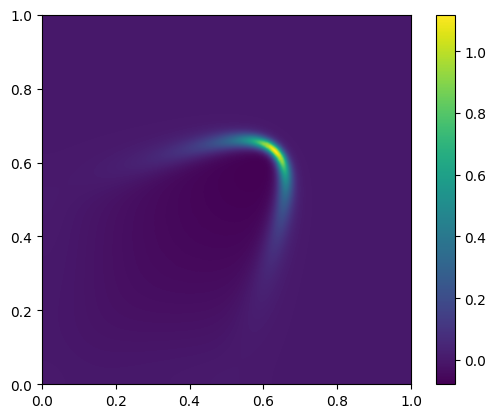

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[499].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

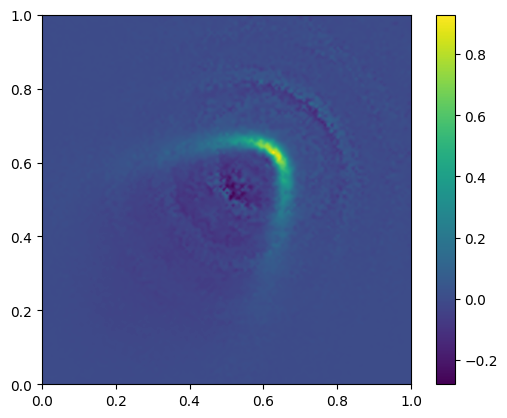

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

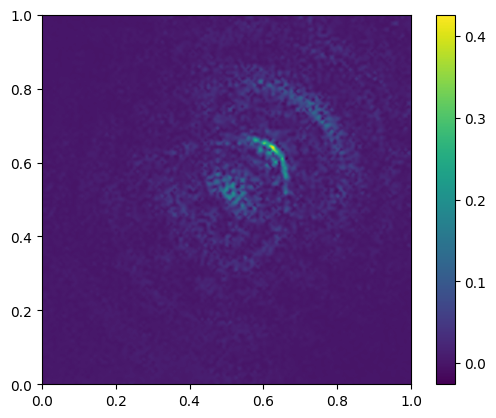

In [21]:
err = abs(datas[499] - approximates[0].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
bws = torch.sigmoid(bws)

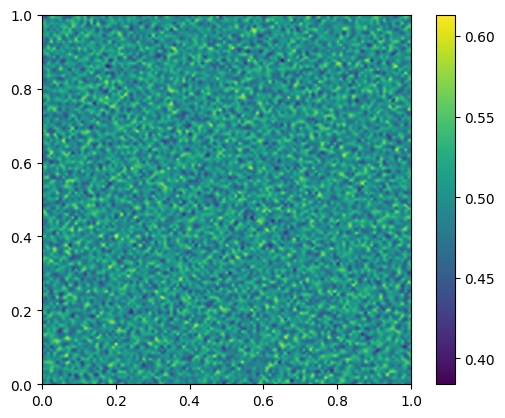

In [ ]:
# data coordinates and values
z = bws[1].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()